In [1]:
import torch
import requests
import os
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [2]:
Noise_0_dataframe = pd.read_csv("../Data/Assignment1/data_0_noise")
Noise_Low_dataframe = pd.read_csv("../Data/Assignment1/data_Low_noise")
Noise_High_dataframe = pd.read_csv("../Data/Assignment1/data_High_noise")

In [13]:
dataframe=Noise_Low_dataframe
validation_dataframe=Noise_Low_dataframe
target_columns="target_10_val"

In [14]:
to_encode = "target_10_val"
class_index = list(dataframe[to_encode].unique())
def encode(value, class_index = class_index):
    return class_index.index(value)

dataframe[to_encode] = dataframe[to_encode].apply(encode)
validation_dataframe[to_encode] = validation_dataframe[to_encode].apply(encode)

In [15]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, noise, transform=None, target_transform=None, drop=None, target=None):
        self.dataframe = dataframe
        if drop != None:
            self.X = dataframe.drop(drop, axis=1).values
        else:
            self.X = dataframe.values
        
        self.y = dataframe[target].values
        self.transform = transform
        self.target_transform = target_transform
        self.noise = noise

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        item, label = self.X[idx], self.y[idx]
        return item, label

    def get_noise(self):
        return self.noise

In [16]:
dataset = CustomDataset(dataframe, "0",drop = ["row_num","day","era","target_10_val","target_5_val","data_type"],target=target_columns)
Noise_train, Noise_test = random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])
Noise_train_loader = DataLoader(Noise_train, batch_size=128, shuffle=True)
Noise_test_loader = DataLoader(Noise_test, batch_size=128, shuffle=True)

In [17]:
class EncoderClassifier(torch.nn.Module):
    def __init__(self, encoder, latent_dim, layers, subset_size, overlap, activation=torch.nn.ReLU()):
        super().__init__()
        self.encoder = encoder
        self.layers = []
        linear = [torch.nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]
        self.latent_layer = torch.nn.Linear(latent_dim, layers[0])
        
        for i in range(len(linear)):
            if (i == 0 or i == len(linear)-1):
                self.layers.append(linear[i])
            else:
                self.layers.append(linear[i])
                self.layers.append(activation)

        self.layers = torch.nn.Sequential(*self.layers)
        self.subset_size = subset_size
        self.overlap = overlap
        self.softmax = torch.nn.Softmax(dim=1)
        self.att_layer = torch.nn.Linear(latent_dim, 1)
        self.sigmoid = torch.nn.Sigmoid()
        self.lrelu = torch.nn.LeakyReLU()

    def forward(self, X):
        subsets = []
        num_columns = X.shape[1]
        for i in range(0, num_columns-self.subset_size, self.subset_size-self.overlap):
            subsets.append(X[:, i:i+self.subset_size])

        preds = 0
        h = 0
        for subset in subsets:
            pred = self.encoder(subset)
            pred = self.latent_layer(pred)
            h = self.att_layer(pred)
            pred = self.lrelu(pred)
            pred = self.layers(pred)
            pred = self.softmax(pred)
            preds += pred

        h = h/len(subsets)
        h = self.sigmoid(h)
        preds = preds/len(subsets)

        return preds, h

In [18]:
class SubsetAutoencoder (torch.nn.Module):
    def __init__(self, encoder_sizes,decoder_sizes,activation = torch.nn.ReLU()):
        super().__init__()
        linear_encoder = [torch.nn.Linear(encoder_sizes[i],encoder_sizes[i+1]) for i in range(len(encoder_sizes)-1)]
        linear_decoder = [torch.nn.Linear(decoder_sizes[i],decoder_sizes[i+1]) for i in range(len(decoder_sizes)-1)]
        self.encoder = torch.nn.Sequential(*[l for layer in linear_encoder for l in (layer, activation)])
        self.decoder = torch.nn.Sequential(*[l for layer in linear_decoder for l in (layer, activation)])
        
    def forward(self,X):
        X = self.encoder(X)
        X = self.decoder(X)
        return X
    
    def get_encoder(self):
        return self.encoder
    
    def get_decoder(self):
        return self.decoder

In [19]:
import torch.nn as nn

class CustomLoss(nn.Module):
    def __init__(self,reg,no_of_class=12):
        super(CustomLoss, self).__init__()
        self.reg=reg
        self.no_of_class=no_of_class

    def forward(self, inputs, targets):
        p=torch.Tensor(inputs[0]).to(device).t()
        # Converting to 64 X 12 to 64 X 1
        # _,p=torch.max(p,1)
        targets=torch.eye(self.no_of_class).to(device)[targets].t()
        tou=torch.Tensor(inputs[1]).to(device)
        tou=tou.t()
        # print("tou",tou)
        # print(tou)
        loss_a= torch.t(targets)@torch.log(tou*(p-targets)+targets)
        loss_b=self.reg*torch.log(tou)
        loss_a=loss_a.diag().t()
        # print("Loss a",loss_a)
        # print("Loss b",loss_b)
        loss=loss_a+loss_b
        # print("loss",loss.shape)
        # print("return",loss.mean().shape)
        return -loss.mean()

    def custom_p(p):
        return p

In [20]:
def get_subsets(current_batch,subset_size,overlap):
        subsets = []
        num_columns = current_batch.shape[1]
        for i in range(0, num_columns-subset_size,subset_size-overlap):
            subsets.append(current_batch[:,i:i+subset_size])
        return subsets


def train_ae(model,criterion,optimizer,epochs,trainloader,testloader,subset_size = 10,overlap = 4,lr = 0.001 , verbose = True):
    optimizer = optimizer(model.parameters(), lr=lr)
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        current_train_loss = 0
        current_accuracy = []
        for data, _ in tqdm(trainloader,desc = "Training Epoch "+str(epoch)):
            data= data.to(device).float()
            subsets = get_subsets(data,subset_size,overlap)
            optimizer.zero_grad()
            recons = []
            subset_loss = 0
            for subset in subsets:
                output = model(subset)
                recons.append(output)
                subset_loss += criterion(data,output)
            subset_loss = subset_loss.mean()
            subset_loss.backward()
            optimizer.step()
        print(f"epoch-{epoch} loss:",subset_loss)
        
def train_classifier(model,criterion,optimizer,epochs,trainloader,testloader,lr=0.001,verbose = True,subset_size = 10,overlap = 2):
    optimizer = optimizer(model.parameters(), lr=lr)
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        running_train_loss = 0
        total_train = 0
        correct_train = 0
        current_accuracy = []
        for data, target in tqdm(trainloader,desc = "Training Epoch "+str(epoch)):
            data, target = data.to(device).float(), target.to(device).long()
            subsets = get_subsets(data,subset_size,overlap)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(output[0], 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()
            current_accuracy.append(correct_train/total_train)
            running_train_loss+=loss
        
        running_train_loss /= len(trainloader)    
        print(f"epoch-{epoch} loss:{running_train_loss} accuracy:{correct_train/total_train}")

In [21]:
def train_classifier(model, criterion, optimizer, epochs, trainloader, testloader, lr=0.001, verbose=True, subset_size=10, overlap=2):
    optimizer = optimizer(model.parameters(), lr=lr)
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
    
    for epoch in range(epochs):
        running_train_loss = 0
        total_train = 0
        correct_train = 0
        
        # Training
        model.train()
        for data, target in tqdm(trainloader, desc="Training Epoch " + str(epoch)):
            data, target = data.to(device).float(), target.to(device).long()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(output[0], 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()
            running_train_loss += loss.item()
            
        accuracy = correct_train / total_train
        train_accuracy.append(accuracy)
        running_train_loss /= len(trainloader)
        train_loss.append(running_train_loss)
        
        # Validation
        model.eval()
        running_val_loss = 0
        total_val = 0
        correct_val = 0
        with torch.no_grad():
            for data, target in tqdm(testloader, desc="Validation Epoch " + str(epoch)):
                data, target = data.to(device).float(), target.to(device).long()
                output = model(data)
                loss = criterion(output, target)
                running_val_loss += loss.item()
                
                _, predicted = torch.max(output[0], 1)
                total_val += target.size(0)
                correct_val += (predicted == target).sum().item()
        
        running_val_loss /= len(testloader)
        val_loss.append(running_val_loss)
        accuracy_val = correct_val / total_val
        val_accuracy.append(accuracy_val)
        
        if verbose:
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {accuracy:.4f}, Validation Loss: {val_loss[-1]:.4f}, Validation Accuracy: {accuracy_val:.4f}")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
    
    return train_loss, val_loss, train_accuracy, val_accuracy

In [22]:
def train_ae(model, criterion, optimizer, epochs, trainloader, testloader, subset_size=10, overlap=4, lr=0.001, verbose=True):
    optimizer = optimizer(model.parameters(), lr=lr)
    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        # Training
        model.train()
        current_train_loss = 0
        for data, _ in tqdm(trainloader, desc="Training Epoch " + str(epoch)):
            data = data.to(device).float()
            subsets = get_subsets(data, subset_size, overlap)
            optimizer.zero_grad()
            recons = []
            subset_loss = 0
            for subset in subsets:
                output = model(subset)
                recons.append(output)
                subset_loss += criterion(data, output)
            subset_loss = subset_loss.mean()
            subset_loss.backward()
            optimizer.step()
            current_train_loss += subset_loss.item() * data.size(0)
        train_loss.append(current_train_loss / len(trainloader.dataset))
        
        # Validation
        model.eval()
        current_val_loss = 0
        with torch.no_grad():
            for data, _ in tqdm(testloader, desc="Validation Epoch " + str(epoch)):
                data = data.to(device).float()
                subsets = get_subsets(data, subset_size, overlap)
                recons = []
                subset_loss = 0
                for subset in subsets:
                    output = model(subset)
                    recons.append(output)
                    subset_loss += criterion(data, output)
                subset_loss = subset_loss.mean()
                current_val_loss += subset_loss.item() * data.size(0)
            val_loss.append(current_val_loss / len(testloader.dataset))
        
        if verbose:
            print(f"Epoch [{epoch}/{epochs}], Train Loss: {train_loss[-1]}, Validation Loss: {val_loss[-1]}")
        
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    return train_loss, val_loss

In [23]:
model = SubsetAutoencoder(encoder_sizes=[12,32,16,8],decoder_sizes=[8,16,32,24])
model.to(device)

SubsetAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=24, bias=True)
    (5): ReLU()
  )
)

Validation Epoch 0: 100%|██████████| 488/488 [00:03<00:00, 140.48it/s]


Epoch [0/2], Train Loss: 0.1819122635706877, Validation Loss: 0.145564275934146


Validation Epoch 1: 100%|██████████| 488/488 [00:04<00:00, 116.51it/s]


Epoch [1/2], Train Loss: 0.14334449485326425, Validation Loss: 0.1416709509721169


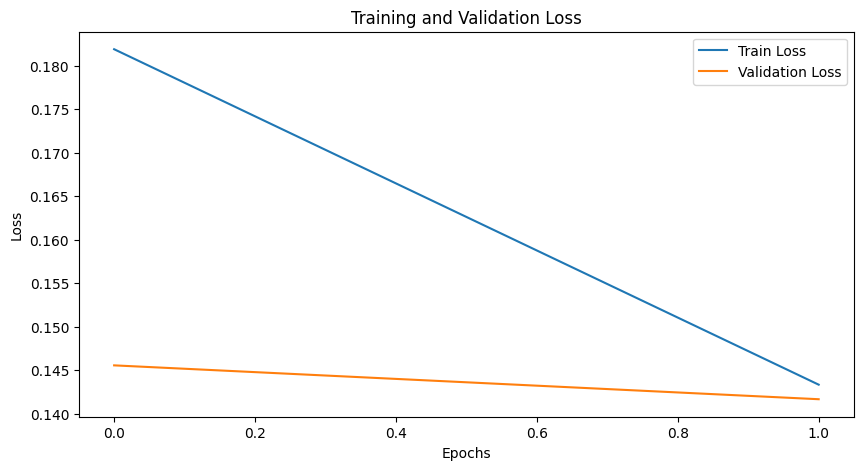

([0.1819122635706877, 0.14334449485326425],
 [0.145564275934146, 0.1416709509721169])

In [14]:
optimizer = torch.optim.Adam
criterion = torch.nn.MSELoss()
train_ae(model,criterion,optimizer,2,Noise_train_loader,Noise_test_loader,subset_size = 12,overlap = 2)

In [24]:
encoder = model.get_encoder()

In [25]:
classifier = EncoderClassifier(encoder,8,[8,5],12,6)
classifier = classifier.to(device)
print(classifier)

EncoderClassifier(
  (encoder): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
  )
  (latent_layer): Linear(in_features=8, out_features=8, bias=True)
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=5, bias=True)
  )
  (softmax): Softmax(dim=1)
  (att_layer): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (lrelu): LeakyReLU(negative_slope=0.01)
)


Validation Epoch 0: 100%|██████████| 488/488 [00:04<00:00, 98.66it/s] 


Epoch [1/1], Train Loss: 2.7167, Train Accuracy: 0.4426, Validation Loss: 1.1276, Validation Accuracy: 0.6102


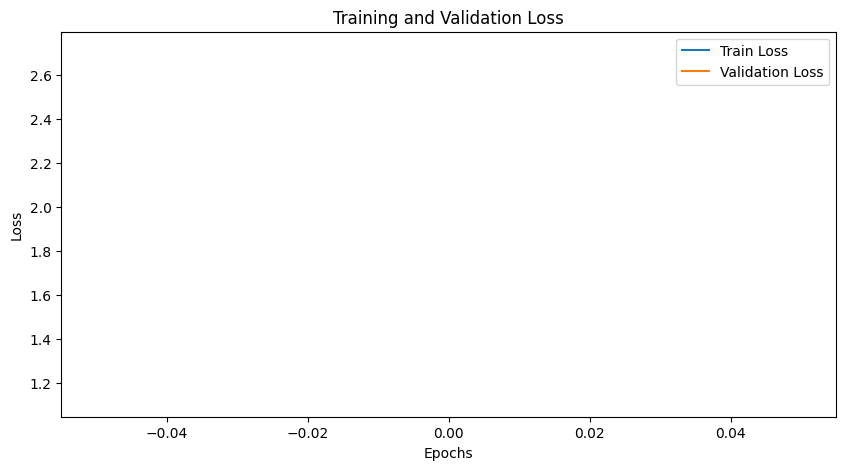

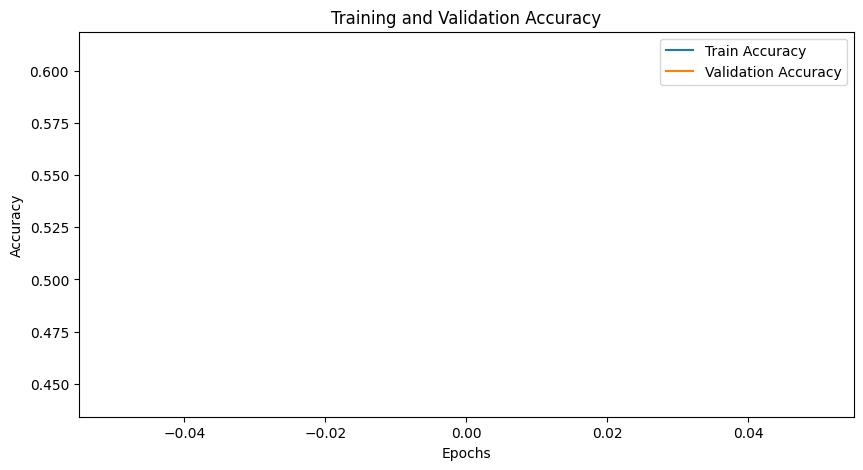

In [19]:
train_loss,val_loss,t_acc,v_acc=train_classifier(classifier,CustomLoss(50,no_of_class=5),torch.optim.Adam,1,Noise_train_loader,Noise_test_loader,subset_size = 12,overlap = 6)

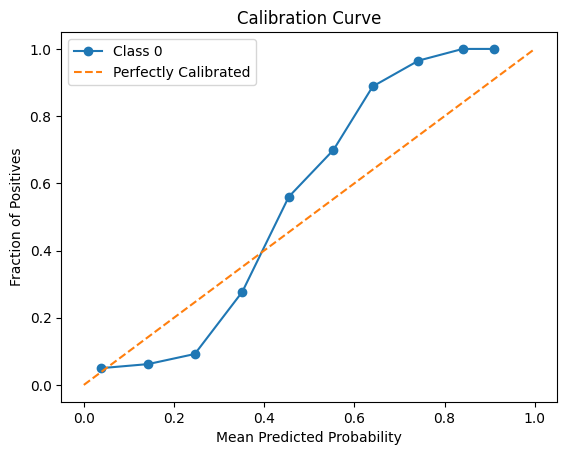

In [21]:
# Choose Class
cls=0



import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import torch

def binarize(target, c):
    return np.array([1 if t == c else 0 for t in target])

Model=classifier
Model.eval()  # Set model to evaluation mode
y_true = []
y_probabilities = []

# Iterate over test_loader to get predictions and true labels
for inputs, labels in Noise_test_loader:
    inputs, labels = inputs.to(device).to(torch.float32), labels.to(device).to(torch.long)

    # Forward pass
    outputs = Model(inputs)
    probabilities = outputs[0]
    
    y_true.extend(labels.cpu().numpy())  # Collect true labels
    y_probabilities.extend(probabilities[:, 0].detach().cpu().numpy())  # Collect probabilities for class 0

y_true_binarized = binarize(y_true, 0)
# Calculate calibration curve
prob_true, prob_pred = calibration_curve(y_true_binarized, y_probabilities, n_bins=10)

# Plot calibration curve
plt.plot(prob_pred, prob_true, marker='o', label="Class")
plt.plot([0, 1], [0, 1], linestyle='--', label="Perfectly Calibrated")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend()
plt.show()